In [2]:
#Importing the necessary libraries:
import cv2 as cv
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import os

In [3]:
#Initializing the values needed for all the image files
normaldir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Normal'
tbdir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database/Tuberculosis'
images = []
labels = []
imagesize = 150

In [4]:
#Storing all the image directories in the 'images' array and corresponding them to either 1 for TB images or 0 for normal images.
for x in os.listdir(normaldir):
    imagedir = os.path.join(normaldir, x)
    image = cv.imread(imagedir, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (imagesize, imagesize))
    images.append(image)
    labels.append(0)
    
for y in os.listdir(tbdir):
    imagedir = os.path.join(tbdir, y)
    image = cv.imread(imagedir, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = cv.resize(image, (imagesize, imagesize))
    images.append(image)
    labels.append(1)

In [5]:
#Converting to NumPy arrays since they have more features than regular lists
images = np.array(images)
labels = np.array(labels)

#Splitting the images and labels into training and testing sets, then normalizing the values within them for computational efficiency (from 0-255 scale to 0-1 scale)
imagetrain, imagetest, labeltrain, labeltest = train_test_split(images, labels, test_size=0.3, random_state=42)
imagetrain = (imagetrain.astype('float32'))/255
imagetest = (imagetest.astype('float32'))/255

In [6]:
num_images = imagetrain.size // (imagesize * imagesize*3)
print(num_images)

2940


In [7]:
#Flattening the image array into 2D (making it [2940 images] x [all the pixels of the image in just one 1D array]) to be suitable for SMOTE oversampling
imagetrain = imagetrain.reshape(num_images, (imagesize*imagesize*3))

#Performing oversampling
smote = SMOTE(random_state=42)
imagetrain, labeltrain = smote.fit_resample(imagetrain, labeltrain)

#Unflattening the images now to use them for convolutional neural network (4914 images of 256x256 size, with 1 color channel (grayscale, as compared to RGB with 3 color channels))
imagetrain = imagetrain.reshape(-1, imagesize, imagesize, 3)
print(imagetrain.shape)

(4914, 150, 150, 3)


In [8]:
#Classes balanced - equal counts of each label
print(np.unique(labeltrain, return_counts=True))

(array([0, 1]), array([2457, 2457]))


In [9]:
#Importing the necessary libraries
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [10]:
from keras.applications.vgg16 import VGG16
conv_base=VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150,150,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False
    
for layer in conv_base.layers:
    print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [12]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [13]:
from keras import Sequential
# Create the Sequential model and add the conv_base and FC layers
model = Sequential()
model.add(conv_base)
model.add(Flatten())

# Adding fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Optional: Adding dropout to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Optional: Adding another dropout layer
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

In [14]:
#Compiling the model with parameters best suited for the task at hand:
model.compile(
    loss='binary_crossentropy', #Best for binary classification
    optimizer = keras.optimizers.Adam(learning_rate=0.001), #Good starting LR for dataset of this size
    metrics=['accuracy'], #Looking for accuracy
)

In [20]:
#Fitting the model, with the ReduceLROnPlateau callback added to it to reduce the learning rate to take smaller steps in increasing the accuracy whenever the learning rate plateaus (goes in the wrong direction)
#Doing this with patience=1, meaning it will perform this if it even plateaus for one epoch, since only 10 epochs are used
#factor=0.1 means that for every time the learning rate is reduced, it is reduced by a factor of 0.1 - it also won't go lower than 0.00001
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=1, min_lr=0.00001, verbose=1)

#Fitting the model w/ the callback. ON VS CODE, batch size of 16 makes each epoch take around a minute in this case w/ good accuracy, making the whole training process 10 min, but on Kaggle it should take longer due to less computational resources:
history = model.fit(imagetrain, labeltrain, batch_size=16, epochs=10, verbose=2, callbacks = [reduce_lr],validation_split=0.2)

Epoch 1/10
246/246 - 14s - 58ms/step - accuracy: 0.9972 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 4.8826e-04 - learning_rate: 1.0000e-05
Epoch 2/10
246/246 - 14s - 56ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 6.2442e-04 - learning_rate: 1.0000e-05
Epoch 3/10
246/246 - 14s - 57ms/step - accuracy: 0.9985 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 3.6664e-04 - learning_rate: 1.0000e-05
Epoch 4/10
246/246 - 14s - 57ms/step - accuracy: 0.9985 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 4.0391e-04 - learning_rate: 1.0000e-05
Epoch 5/10
246/246 - 14s - 58ms/step - accuracy: 0.9982 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 3.3949e-04 - learning_rate: 1.0000e-05
Epoch 6/10
246/246 - 14s - 57ms/step - accuracy: 0.9985 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 4.1328e-04 - learning_rate: 1.0000e-05
Epoch 7/10
246/246 - 14s - 57ms/step - accuracy: 0.9990 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 3.5806e-04 - learning_ra

In [21]:
print("Loss of the model is - " , model.evaluate(imagetest,labeltest)[0])
print("Accuracy of the model is - " , model.evaluate(imagetest,labeltest)[1]*100 , "%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9973 - loss: 0.0136
Loss of the model is -  0.01911899819970131
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9973 - loss: 0.0136
Accuracy of the model is -  99.68253970146179 %


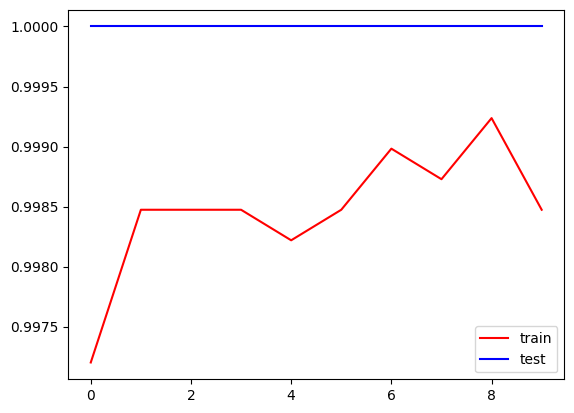

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='test')
plt.legend()
plt.show()

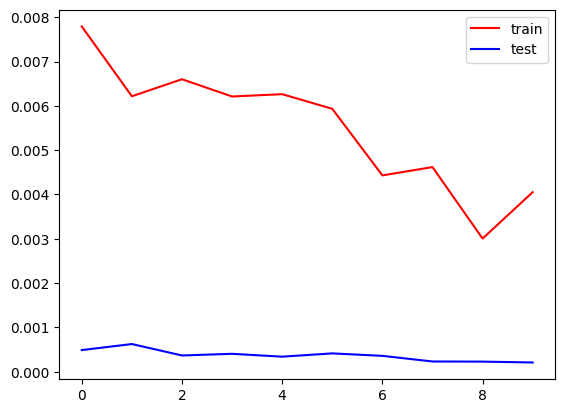

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='test')
plt.legend()
plt.show()

In [26]:
#Evaluating the data w/ multiple types of metrics
print('TESTING DATA:')
model.evaluate(imagetest, labeltest, batch_size=32, verbose=2)

print('ADVANCED TESTING METRICS:')
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(imagetest, batch_size=32)
predicted_labels = (predictions > 0.5).astype('int32')
print(classification_report(labeltest, predicted_labels))
print('----CONFUSION MATRICS----')
print(confusion_matrix(labeltest, predicted_labels))

TESTING DATA:
40/40 - 3s - 63ms/step - accuracy: 0.9968 - loss: 0.0191
ADVANCED TESTING METRICS:
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1043
           1       0.99      1.00      0.99       217

    accuracy                           1.00      1260
   macro avg       0.99      1.00      0.99      1260
weighted avg       1.00      1.00      1.00      1260

----CONFUSION MATRICS----
[[1040    3]
 [   1  216]]
